In [1]:
%ls

adc.json  dog_dataset.zip  sample_data/


In [2]:
%cd ~
  
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

%cd ~/models/research
!protoc object_detection/protos/*.proto --python_out=.

/root
fatal: destination path 'models' already exists and is not an empty directory.
/root/models/research


In [3]:
!python setup.py build
!python setup.py install

running build
running build_py
creating build
creating build/lib.linux-x86_64-2.7
creating build/lib.linux-x86_64-2.7/object_detection
copying object_detection/export_inference_graph.py -> build/lib.linux-x86_64-2.7/object_detection
copying object_detection/export_tflite_ssd_graph_lib_test.py -> build/lib.linux-x86_64-2.7/object_detection
copying object_detection/model_tpu_main.py -> build/lib.linux-x86_64-2.7/object_detection
copying object_detection/model_lib.py -> build/lib.linux-x86_64-2.7/object_detection
copying object_detection/eval_util_test.py -> build/lib.linux-x86_64-2.7/object_detection
copying object_detection/inputs_test.py -> build/lib.linux-x86_64-2.7/object_detection
copying object_detection/inputs.py -> build/lib.linux-x86_64-2.7/object_detection
copying object_detection/export_tflite_ssd_graph.py -> build/lib.linux-x86_64-2.7/object_detection
copying object_detection/eval_util.py -> build/lib.linux-x86_64-2.7/object_detection
copying object_detection/exporter.py -> b

In [4]:
%cd slim

/root/models/research/slim


In [5]:
!pip install -e .

Obtaining file:///root/models/research/slim
  Running setup.py develop for slim


In [6]:
%cd ..
!python object_detection/builders/model_builder_test.py

/root/models/research
......................
----------------------------------------------------------------------
Ran 22 tests in 0.120s

OK


In [7]:
%cd ~
!mkdir datalab

/root


In [8]:
%cd ~/datalab

/root/datalab


In [9]:
!echo "item { id: 1 name: 'dog'}" > label_map.pbtxt


fileId = '1Xm4jwKGnRrr4eiO9RTf9DzCRQwj_ZW8H'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

image_files=os.listdir('images')
im_files=[x.split('.')[0] for x in image_files]
with open('annotations/trainval.txt', 'w') as text_file:
  for row in im_files:
    text_file.write(row + '\n')

Extracted zip file 1Xm4jwKGnRrr4eiO9RTf9DzCRQwj_ZW8H.zip


In [10]:
%cd ~/datalab/annotations

!mkdir trimaps

from PIL import Image
image = Image.new('RGB', (640, 480))

for filename in os.listdir('xmls'):
  filename = os.path.splitext(filename)[0]
  image.save('trimaps/' + filename + '.png')

/root/datalab/annotations


In [12]:
!cat label_map.pbtxt

cat: label_map.pbtxt: No such file or directory


In [13]:
!apt-get -y install protobuf-compiler python-pil python-lxml

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pil is already the newest version (5.1.0-1).
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-lxml is already the newest version (4.2.1-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [14]:
%cd ~/datalab

!python ~/models/research/object_detection/dataset_tools/create_pet_tf_record.py --label_map_path=label_map.pbtxt --data_dir=. --output_dir=. --num_shards=1



/root/datalab
/usr/local/lib/python2.7/dist-packages/object_detection-0.1-py2.7.egg/object_detection/utils/dataset_util.py:75: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:


In [0]:
!mv pet_faces_train.record-00000-of-00001 tf_train.record

!mv pet_faces_val.record-00000-of-00001 tf_val.record

In [16]:
!ls

annotations  images  label_map.pbtxt  tf_train.record  tf_val.record


In [17]:
%cd ~/datalab

import os
import shutil
import glob
import urllib
import tarfile

MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  opener = urllib.URLopener()
  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/root/datalab


In [18]:
%cd ~/datalab

import re

#filename = '/content/datalab/pretrained_model/pipeline.config'
filename = '/root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config'
with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/root/datalab/pretrained_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_train.record-\?\?\?\?\?-of-00010', '/root/datalab/tf_train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_val.record-\?\?\?\?\?-of-00010', '/root/datalab/tf_val.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_label_map.pbtxt', '/root/datalab/label_map.pbtxt', s)
  f.write(s)

/root/datalab


In [19]:
!cat /root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 37
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        tr

In [20]:
%cd ~/datalab

!python ~/models/research/object_detection/model_main.py \
    --pipeline_config_path=/root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --model_dir=/root/datalab/trained \
    --alsologtostderr \
    --num_train_steps=3000 \
    --num_eval_steps=500

/root/datalab
/usr/local/lib/python2.7/dist-packages/object_detection-0.1-py2.7.egg/object_detection/utils/visualization_utils.py:26: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/root/models/research/object_detection/model_main.py", line 26, in <module>
    from object_detection import model_lib
  File "/usr/local/lib/python2.7/dist-packages/object_detection-0.1-py2.7.egg/object_detection/model_lib.py", line 27, in <module>
    from object_detection import eval_util
  File "/usr/local/lib/python2.7/dist-packages/object_detection-0.1-py2.7.egg/object_detection/eval_util.py", line 27, in <module>
    from object_detection.metrics import coco_evaluation
  File "/usr/local/lib/python2.7/dist-packages/obj

In [21]:
!ls trained

checkpoint
eval_0
events.out.tfevents.1546640344.4df50826b7c4
export
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-1992.data-00000-of-00001
model.ckpt-1992.index
model.ckpt-1992.meta
model.ckpt-3000.data-00000-of-00001
model.ckpt-3000.index
model.ckpt-3000.meta


In [22]:
%cd ~/datalab

lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')

!python ~/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model

/root/datalab
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
357 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by                   name
-account_type_regexes       _trainable_variables
-start_name_regexes         .*
-trim_name_regexes          .*Ba

In [23]:
!ls fine_tuned_model

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


In [27]:
%cd ~/datalab

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

/root/datalab


Saving dogs2.jpg to dogs2.jpg
saved file dogs2.jpg


In [28]:
!ls

annotations	  image1.jpg	   pretrained_model  tf_val.record
dogs2.jpg	  images	   test_doggie.jpg   trained
fine_tuned_model  label_map.pbtxt  tf_train.record


/root/models/research/object_detection


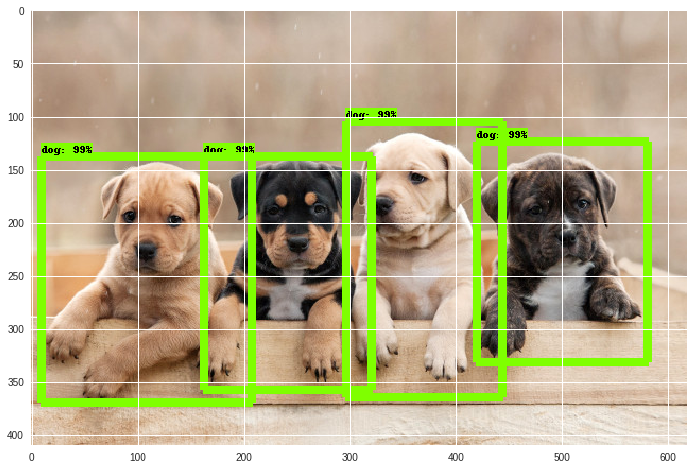

In [29]:
%cd ~/models/research/object_detection




import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

# if tf.__version__ < '1.4.0':
#   raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
  

  
  
# This is needed to display the images.
%matplotlib inline




from utils import label_map_util

from utils import visualization_utils as vis_util




# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/root/datalab/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/root/datalab', 'label_map.pbtxt')

NUM_CLASSES = 37




detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)




def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/root/datalab/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)




def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict




for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)